In [23]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from peft import get_peft_model, LoraConfig, TaskType
import gc
from pathlib import Path
import warnings
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import os
import wandb  # ADDED: Import W&B
warnings.filterwarnings('ignore')


In [24]:
wandb.init(
    project="emotion-classification-v2",
    name="wav2vec2-emotion-improved",
    config={
        "learning_rate": 1e-5,
        "batch_size": 2,
        "epochs": 15,
        "model": "wav2vec2-base",
        "weight_decay": 0.01,
        "warmup_steps": 100
    }
)

wandb: Currently logged in as: istatiehahmad0 (istatiehahmad0-an-najah-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [26]:
DATA_DIR = Path("/teamspace/studios/this_studio/processed_data")

# Load parquet files
#train_df = pd.read_parquet(DATA_DIR / "train_processed.parquet")
#valid_df = pd.read_parquet(DATA_DIR / "valid_processed.parquet")
test_df  = pd.read_parquet(DATA_DIR / "test_processed.parquet")
test_df2  = pd.read_parquet(DATA_DIR / "test_processed.parquet")


In [27]:
#comment this cell if yo want to not drop labels dont forget to change the number of classes in the model
#train_df = train_df[~train_df['labels'].isin([2, 3])]
#valid_df = valid_df[~valid_df['labels'].isin([2, 3])]
test_df = test_df[~test_df['labels'].isin([2, 3])]

# Remap labels to remove gaps
# Original: 0=angry, 1=calm, 2=disgust, 3=fear, 4=happy, 5=sad, 6=surprise
# New: 0=angry, 1=calm, 2=happy, 3=sad, 4=surprise
label_mapping = {0: 0, 1: 1, 4: 2, 5: 3, 6: 4}

#train_df['labels'] = train_df['labels'].map(label_mapping)
#valid_df['labels'] = valid_df['labels'].map(label_mapping)
test_df['labels'] = test_df['labels'].map(label_mapping)

print(f"After filtering:")
#print(f"Train samples: {len(train_df)}")
#print(f"Valid samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")


After filtering:
Test samples: 823


In [5]:
wandb.log({
    "train_samples": len(train_df),
    "valid_samples": len(valid_df),
    "test_samples": len(test_df)
})

In [6]:
# DEBUGGING: Check label distributions
print("=== DEBUGGING LABEL DISTRIBUTIONS ===")
print(f"Train labels: min={train_df['labels'].min()}, max={train_df['labels'].max()}")
print(f"Valid labels: min={valid_df['labels'].min()}, max={valid_df['labels'].max()}")
print(f"Test labels: min={test_df['labels'].min()}, max={test_df['labels'].max()}")

print("\nTrain label distribution:")
print(train_df['labels'].value_counts().sort_index())
print("\nValid label distribution:")
print(valid_df['labels'].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df['labels'].value_counts().sort_index())

# Check for any NaN or invalid values
print(f"\nNaN values in train labels: {train_df['labels'].isna().sum()}")
print(f"NaN values in valid labels: {valid_df['labels'].isna().sum()}")
print(f"NaN values in test labels: {test_df['labels'].isna().sum()}")


=== DEBUGGING LABEL DISTRIBUTIONS ===
Train labels: min=0, max=4
Valid labels: min=0, max=4
Test labels: min=0, max=4

Train label distribution:
labels
0    1538
1    1516
2    1538
3    1534
4     473
Name: count, dtype: int64

Valid label distribution:
labels
0    191
1    189
2    193
3    192
4     59
Name: count, dtype: int64

Test label distribution:
labels
0    192
1    188
2    192
3    192
4     59
Name: count, dtype: int64

NaN values in train labels: 0
NaN values in valid labels: 0
NaN values in test labels: 0


In [28]:
#train_dist = train_df['labels'].value_counts().sort_index()
#valid_dist = valid_df['labels'].value_counts().sort_index()
test_dist = test_df['labels'].value_counts().sort_index()

print("\nTrain label distribution:")
#print(train_dist)
"""wandb.log({
    #"train_label_distribution": wandb.Histogram(train_df['labels'].values),
    #"valid_label_distribution": wandb.Histogram(valid_df['labels'].values),
    "test_label_distribution": wandb.Histogram(test_df['labels'].values)
})"""

label_counts = []
for label in range(7):
    label_counts.append([
        label,
        #train_dist.get(label, 0),
        #valid_dist.get(label, 0),
        test_dist.get(label, 0)
    ])

"""wandb.log({
    "label_distribution_table": wandb.Table(
        data=label_counts,
        columns=["Label", "Train Count", "Valid Count", "Test Count"]
    )
})"""


Train label distribution:


'wandb.log({\n    "label_distribution_table": wandb.Table(\n        data=label_counts,\n        columns=["Label", "Train Count", "Valid Count", "Test Count"]\n    )\n})'

In [29]:
from datasets import Dataset

def create_generator(df):
    for _, row in df.iterrows():
        yield row.to_dict()

#train_dataset = Dataset.from_generator(lambda: create_generator(train_df))
#valid_dataset = Dataset.from_generator(lambda: create_generator(valid_df))
test_dataset = Dataset.from_generator(lambda: create_generator(test_df))
#test_dataset2 = Dataset.from_generator(lambda: create_generator(test_df2))




In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#wandb.log({"device": str(device)})

MODEL_NAME = "facebook/wav2vec2-large-960h-lv60-self"
NUM_LABELS = 5

processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification",
).to(device)

# ADDED: Log model info to W&B
wandb.log({
    "model_parameters": sum(p.numel() for p in model.parameters()),
    "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
})


In [10]:
"""
#V2 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb.log({"device": str(device)})

MODEL_NAME = "facebook/wav2vec2-large-960h-lv60-self"
NUM_LABELS = 7 

processor = Wav2Vec2Processor.from_pretrained(
    "/teamspace/studios/this_studio/wav2vec2_finetuned"
)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "/teamspace/studios/this_studio/wav2vec2-emotion/checkpoint-45961", 
    num_labels=NUM_LABELS,
    problem_type="single_label_classification",
    # Modified: increased dropout for better regularization
    hidden_dropout=0.3,
    activation_dropout=0.3,
    attention_dropout=0.3,
    feat_proj_dropout=0.3,
    final_dropout=0.4,
    layerdrop=0.2
).to(device)
# ADDED: Log model info to W&B
wandb.log({
    "model_parameters": sum(p.numel() for p in model.parameters()),
    "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
})
"""

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nwandb.log({"device": str(device)})\n\nMODEL_NAME = "facebook/wav2vec2-large-960h-lv60-self"\nNUM_LABELS = 7 \n\nprocessor = Wav2Vec2Processor.from_pretrained(\n    "/teamspace/studios/this_studio/wav2vec2_finetuned"\n)\nmodel = Wav2Vec2ForSequenceClassification.from_pretrained(\n    "/teamspace/studios/this_studio/wav2vec2-emotion/checkpoint-45961", \n    num_labels=NUM_LABELS,\n    problem_type="single_label_classification",\n    # Modified: increased dropout for better regularization\n    hidden_dropout=0.3,\n    activation_dropout=0.3,\n    attention_dropout=0.3,\n    feat_proj_dropout=0.3,\n    final_dropout=0.4,\n    layerdrop=0.2\n).to(device)\n# ADDED: Log model info to W&B\nwandb.log({\n    "model_parameters": sum(p.numel() for p in model.parameters()),\n    "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)\n})\n'

In [ ]:
def preprocess_example(example):
    audio = example["input_values"]
    audio = np.array(audio, dtype=np.float32)
    
    max_len = 16000 * 10  # 10 seconds
    if len(audio) > max_len:
        audio = audio[:max_len]
    
    return {
        "input_values": audio,
        "labels": example["labels"]
    }

# Data collator
def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    
    input_values = [torch.tensor(arr, dtype=torch.float32) for arr in input_values]
    max_len = max(len(arr) for arr in input_values)
    
    padded_inputs = []
    for arr in input_values:
        if len(arr) < max_len:
            padded = torch.cat([arr, torch.zeros(max_len - len(arr))])
        else:
            padded = arr
        padded_inputs.append(padded)
    
    return {
        "input_values": torch.stack(padded_inputs),
        "labels": torch.tensor(labels, dtype=torch.long)
    }

# Preprocess datasets
print("Preprocessing datasets...")
test_dataset = test_dataset.map(preprocess_example, batched=False, load_from_cache_file=False)
gc.collect()

Preprocessing datasets...


Map: 100%|##########| 823/823 [00:00<?, ? examples/s]

465

### BASELINE EVALUATION

In [ ]:

from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class DataCollatorCTCWithPadding:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )

        labels_batch = self.processor.tokenizer.pad(
            label_features,
            padding=self.padding,
            return_tensors="pt"
        )

        batch["labels"] = labels_batch["input_ids"]

        return batch

from transformers import (
    Trainer,
    TrainingArguments,
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Set constants
MODEL_NAME = "facebook/wav2vec2-large-960h-lv60-self"
NUM_LABELS = 5

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification",
).to(device)

# Define the data collator
collator = DataCollatorCTCWithPadding(processor=processor)

# Replace this with your actual test dataset
# Example: from datasets import load_dataset
# test_dataset = load_dataset(...)

# Define compute metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Print basic metrics
def print_results(results):
    print("\nEvaluation Results:")
    print("-" * 40)
    print(f"Accuracy:  {results.get('eval_accuracy', results.get('accuracy')):.4f}")
    print(f"Precision: {results.get('eval_precision', results.get('precision')):.4f}")
    print(f"Recall:    {results.get('eval_recall', results.get('recall')):.4f}")
    print(f"F1-Score:  {results.get('eval_f1', results.get('f1')):.4f}")
    print("-" * 40)

# Set up evaluation Trainer
eval_args = TrainingArguments(
    output_dir="./eval_results",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    remove_unused_columns=False,
    report_to=None  # disable WandB or others
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

# Evaluate the model
results = trainer.evaluate()
print_results(results)

# Save metrics
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Results saved to results.json")

# Generate classification report and confusion matrix
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Full classification report (including zero-support classes)
report = classification_report(y_true, y_pred, labels=list(range(NUM_LABELS)), target_names=[
    f"Class_{i}" for i in range(NUM_LABELS)
], digits=4, zero_division=0)
print("\nDetailed Classification Report:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_LABELS)), normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"Class_{i}" for i in range(NUM_LABELS)],
            yticklabels=[f"Class_{i}" for i in range(NUM_LABELS)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


###  FINE TUNNING WAVE2VEC2


In [12]:
# v1 and v3 where tuned with the same parameters in thi cell but with diffrent num of classes
"""
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
    
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')
    
    # Per class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    metrics = {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
    }
    
    # Add per-class F1 scores
    for i in range(len(f1)):
        metrics[f"f1_class_{i}"] = f1[i]
    
    return metrics

training_args = TrainingArguments(
    output_dir="./wav2vec2-emotion-v3",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=20,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    report_to="wandb",  # ADDED: Enable W&B reporting
    run_name="wav2vec2-emotion-finetuning-lessclasses",  # ADDED: Set run name
    logging_dir="./logs",
    resume_from_checkpoint=False,  # ADDED: Set logging directory
)

# Use standard Trainer with W&B integration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

# ADDED: Create a custom training loop with W&B logging
print("Starting training")
try:
    # Start training
    trainer.train()
    
    # ADDED: Log final training metrics
    wandb.log({"training_completed": True})
    
    # Save model
    print("Saving model")
    model.save_pretrained("./wav2vec2_finetuned-v3")
    
    # ADDED: Save model artifact to W&B
    artifact = wandb.Artifact("wav2vec2-finetuned-model-v3", type="model")
    artifact.add_dir("./wav2vec2_finetuned-v3")
    wandb.log_artifact(artifact)
    
    print("Training completed")
    
    # Test the model
    print("Testing model")
    test_results = trainer.evaluate(test_dataset)
    print(f"Test Results: {test_results}")
    
    # ADDED: Log final test results
    wandb.log({
        "final_test_accuracy": test_results["eval_accuracy"],
        "final_test_loss": test_results["eval_loss"]
    })
    
    summary_data = [
        ["Final Test Accuracy", test_results["eval_accuracy"]],
        ["Final Test Loss", test_results["eval_loss"]],
        ["Total Parameters", sum(p.numel() for p in model.parameters())],
        ["Training Samples", len(train_dataset)],
        ["Validation Samples", len(valid_dataset)],
        ["Test Samples", len(test_dataset)]
    ]
    
    wandb.log({
        "training_summary": wandb.Table(
            data=summary_data,
            columns=["Metric", "Value"]
        )
    })
    
except Exception as e:
    # ADDED: Log any errors to W&B
    wandb.log({"error": str(e)})
    raise
finally:
    # ADDED: Properly finish W&B run
    wandb.finish()

print("W&B logging completed")
"""

'\ndef compute_metrics(eval_pred):\n    predictions, labels = eval_pred\n    predictions = np.argmax(predictions, axis=1)\n    \n    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support\n    \n    accuracy = accuracy_score(labels, predictions)\n    macro_f1 = f1_score(labels, predictions, average=\'macro\')\n    \n    # Per class metrics\n    precision, recall, f1, support = precision_recall_fscore_support(\n        labels, predictions, average=None\n    )\n    \n    metrics = {\n        "accuracy": accuracy,\n        "macro_f1": macro_f1,\n    }\n    \n    # Add per-class F1 scores\n    for i in range(len(f1)):\n        metrics[f"f1_class_{i}"] = f1[i]\n    \n    return metrics\n\ntraining_args = TrainingArguments(\n    output_dir="./wav2vec2-emotion-v3",\n    eval_strategy="epoch",\n    save_strategy="epoch",\n    learning_rate=5e-5,\n    per_device_train_batch_size=3,\n    per_device_eval_batch_size=3,\n    num_train_epochs=20,\n    logging_steps=10,

v2.2

In [13]:
"""
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
import shutil
from pathlib import Path
  
# Training arguments with key improvements
training_args = TrainingArguments(
    output_dir="./wav2vec2-emotion-v2.2",
    eval_strategy="epoch", 
    save_strategy="epoch",
    learning_rate=3e-5,  # Slightly higher for dropout
    per_device_train_batch_size=4,  # Larger batch size
    per_device_eval_batch_size=4,
    num_train_epochs=15,  # More epochs for dropout
    weight_decay=0.01,  # Less weight decay since dropout regularizes
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Keep using accuracy (more stable than loss)
    greater_is_better=True,  # Fixed: True for accuracy
    save_total_limit=3,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    report_to="wandb",
    run_name="wav2vec2-emotion-fresh-start",
    logging_dir="./logs-fresh",
    warmup_steps=100,  # More warmup steps
    lr_scheduler_type="cosine",
    resume_from_checkpoint=True,  # Resume from latest checkpoint
    ignore_data_skip=True,
)

# Get class weights
def get_class_weights(train_labels):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    return torch.FloatTensor(class_weights)

train_labels = [item['labels'] for item in train_dataset]
class_weights = get_class_weights(train_labels)
print(f"Class weights: {class_weights}")

# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Use weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
    
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')
    
    # Per class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    
    metrics = {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
    }
    
    # Add per-class F1 scores
    for i in range(len(f1)):
        metrics[f"f1_class_{i}"] = f1[i]
    
    return metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Use existing model (don't reset for checkpoint resume)
model.to(device)

# Use weighted trainer with improved early stopping
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # More patience for dropout
)

print("Starting training")

trainer.train()
"""

'\nfrom transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup\nfrom transformers import EarlyStoppingCallback\nfrom sklearn.utils.class_weight import compute_class_weight\nimport torch\nimport numpy as np\nimport shutil\nfrom pathlib import Path\n  \n# Training arguments with key improvements\ntraining_args = TrainingArguments(\n    output_dir="./wav2vec2-emotion-v2.2",\n    eval_strategy="epoch", \n    save_strategy="epoch",\n    learning_rate=3e-5,  # Slightly higher for dropout\n    per_device_train_batch_size=4,  # Larger batch size\n    per_device_eval_batch_size=4,\n    num_train_epochs=15,  # More epochs for dropout\n    weight_decay=0.01,  # Less weight decay since dropout regularizes\n    logging_steps=50,\n    load_best_model_at_end=True,\n    metric_for_best_model="accuracy",  # Keep using accuracy (more stable than loss)\n    greater_is_better=True,  # Fixed: True for accuracy\n    save_total_limit=3,\n    remove_unused_columns=False,\n    dat

In [20]:
# Check unique labels in test_dataset2
labels = [sample['labels'] if isinstance(sample['labels'], int) else sample['labels'].item()
          for sample in test_dataset]

print("Unique labels in test_dataset2:", set(labels))


Unique labels in test_dataset2: {0, 1, 2, 3, 4}


### Evaluation

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification, Wav2Vec2Config
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from pathlib import Path
import json

def get_model_num_labels(model_path):
    """Get the number of labels from a saved model"""
    checkpoint_path = Path(model_path)
    
    # Look for config.json in the model directory
    config_file = checkpoint_path / "config.json"
    
    if not config_file.exists():
        # Look for checkpoint subdirectories
        checkpoint_dirs = [d for d in checkpoint_path.iterdir() if d.is_dir() and d.name.startswith('checkpoint-')]
        if checkpoint_dirs:
            latest_checkpoint = max(checkpoint_dirs, key=lambda x: int(x.name.split('-')[1]))
            config_file = latest_checkpoint / "config.json"
    
    if config_file.exists():
        with open(config_file, 'r') as f:
            config = json.load(f)
            return config.get('num_labels', 7)  # default to 7 if not found
    
    # If no config found, try to load model without num_labels and inspect
    try:
        model = Wav2Vec2ForSequenceClassification.from_pretrained(str(model_path))
        return model.config.num_labels
    except:
        print(f"Warning: Could not determine num_labels from {model_path}, defaulting to 7")
        return 7

def load_trained_model(model_path, num_labels=None):
    """Load model from checkpoint - auto-detects num_labels if not provided"""
    print(f"Loading model from {model_path}")
    
    checkpoint_path = Path(model_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Model directory {model_path} not found")
    
    # Auto-detect num_labels if not provided
    if num_labels is None:
        num_labels = get_model_num_labels(model_path)
        print(f"Auto-detected {num_labels} labels from model")
    
    # Look for checkpoint subdirectories
    checkpoint_dirs = [d for d in checkpoint_path.iterdir() if d.is_dir() and d.name.startswith('checkpoint-')]
    
    if checkpoint_dirs:
        # Find the latest checkpoint
        latest_checkpoint = max(checkpoint_dirs, key=lambda x: int(x.name.split('-')[1]))
        print(f"Found checkpoint: {latest_checkpoint}")
        # Load model with ignore_mismatched_sizes=True to handle size mismatches
        model = Wav2Vec2ForSequenceClassification.from_pretrained(
            str(latest_checkpoint), 
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
    else:
        # Try to load directly from the path
        try:
            model = Wav2Vec2ForSequenceClassification.from_pretrained(
                str(model_path), 
                num_labels=num_labels,
                ignore_mismatched_sizes=True
            )
        except:
            # Look for any model files
            model_files = list(checkpoint_path.glob("*.bin")) + list(checkpoint_path.glob("*.safetensors"))
            if model_files:
                print(f"Found model files: {model_files}")
                model = Wav2Vec2ForSequenceClassification.from_pretrained(
                    str(model_path), 
                    num_labels=num_labels,
                    ignore_mismatched_sizes=True
                )
            else:
                raise FileNotFoundError(f"No valid model files found in {model_path}")
    
    # Better device handling
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        model = model.to(device)
        print(f"Model loaded successfully on {device}")
    except RuntimeError as e:
        print(f"CUDA error occurred: {e}")
        print("Falling back to CPU...")
        device = torch.device("cpu")
        model = model.to(device)
        print(f"Model loaded successfully on {device}")
    
    return model

def create_evaluation_trainer(model, test_dataset, collate_fn):
    """Create trainer for evaluation - takes a loaded model object"""
    training_args = TrainingArguments(
        output_dir="./temp_eval",
        per_device_eval_batch_size=4,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
    )
    
    return trainer

def create_evaluation_trainer_from_path(model_path, test_dataset, collate_fn):
    """Create trainer for evaluation - takes a model path and loads model first"""
    model = load_trained_model(model_path)
    return create_evaluation_trainer(model, test_dataset, collate_fn)

def print_classification_report(y_true, y_pred, emotion_labels):
    """Print classification report in specific format"""
    from sklearn.metrics import precision_recall_fscore_support
    
    # Get per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Calculate averages
    accuracy = accuracy_score(y_true, y_pred)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    # Weighted averages
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    
    total_support = np.sum(support)
    
    # Print header
    print("Classification Report:")
    print(f"{'':>15} {'precision':>9} {'recall':>9} {'f1-score':>9} {'support':>9}")
    
    # Print per-class results
    for i, label in enumerate(emotion_labels):
        print(f"{f'Class_{i}':>15} {precision[i]:>9.4f} {recall[i]:>9.4f} {f1[i]:>9.4f} {support[i]:>9}")
    
    print()
    print(f"{'accuracy':>15} {accuracy:>9.4f} {total_support:>19}")
    print(f"{'macro avg':>15} {macro_precision:>9.4f} {macro_recall:>9.4f} {macro_f1:>9.4f} {total_support:>9}")
    print(f"{'weighted avg':>15} {weighted_precision:>9.4f} {weighted_recall:>9.4f} {weighted_f1:>9.4f} {total_support:>9}")

def evaluate_single_model(model_path, test_dataset, collate_fn, model_name=None, num_labels=None, show_plot=True):
    """Evaluate a single model and return results - auto-detects num_labels if not provided"""
    
    # Use model name from path if not provided
    if model_name is None:
        model_name = Path(model_path).name
    
    print(f"\n=== Evaluating {model_name} ===")
    
    # Load model (will auto-detect num_labels if not provided)
    model = load_trained_model(model_path, num_labels=num_labels)
    actual_num_labels = model.config.num_labels
    print(f"Using {actual_num_labels} labels for evaluation")
    
    # Create trainer
    trainer = create_evaluation_trainer(model, test_dataset, collate_fn)
    
    # Get predictions
    print("Evaluating on test set...")
    predictions = trainer.predict(test_dataset)
    
    # Extract labels
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    
    # Set emotion labels based on number of classes
    if actual_num_labels == 5:
        emotion_labels = ['angry', 'calm', 'happy', 'sad', 'surprise']
    else:
        emotion_labels = ['angry', 'calm', 'disgust', 'fear', 'happy', 'sad', 'surprise']
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print()
    print_classification_report(y_true, y_pred, emotion_labels)
    
    # Generate confusion matrix plot
    if show_plot:
        cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=emotion_labels,
                    yticklabels=emotion_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Normalized Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.show()
    
    # Return results
    return {
        'model_name': model_name,
        'accuracy': acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': cm,
        'num_labels': actual_num_labels
    }

def compare_models(model_paths, test_datasets, collate_fn, model_names=None, num_labels_list=None):
    """Compare multiple models with different datasets and label counts"""
    
    if model_names is None:
        model_names = [Path(path).name for path in model_paths]
    
    if num_labels_list is None:
        num_labels_list = [None] * len(model_paths)  # Let auto-detection handle it
    
    results = []
    
    # Evaluate each model
    for i, model_path in enumerate(model_paths):
        model_name = model_names[i] if i < len(model_names) else f"model_{i+1}"
        num_labels = num_labels_list[i] if i < len(num_labels_list) else None
        
        # Use appropriate test dataset
        if isinstance(test_datasets, list):
            test_dataset = test_datasets[i] if i < len(test_datasets) else test_datasets[0]
        else:
            test_dataset = test_datasets
        
        result = evaluate_single_model(
            model_path, 
            test_dataset, 
            collate_fn, 
            model_name, 
            num_labels, 
            show_plot=False
        )
        results.append(result)
    
    # Print comparison summary
    print("\n=== MODEL COMPARISON SUMMARY ===")
    print(f"{'Model':<30} {'Labels':<8} {'Accuracy':<10}")
    print("-" * 48)
    for result in results:
        print(f"{result['model_name']:<30} {result['num_labels']:<8} {result['accuracy']:<10.4f}")
    
    # Find best model for each label count
    results_7_labels = [r for r in results if r['num_labels'] == 7]
    results_5_labels = [r for r in results if r['num_labels'] == 5]
    
    if results_7_labels:
        best_7_label = max(results_7_labels, key=lambda x: x['accuracy'])
        print(f"\nBest 7-label Model: {best_7_label['model_name']} (Accuracy: {best_7_label['accuracy']:.4f})")
    
    if results_5_labels:
        best_5_label = max(results_5_labels, key=lambda x: x['accuracy'])
        print(f"Best 5-label Model: {best_5_label['model_name']} (Accuracy: {best_5_label['accuracy']:.4f})")
    
    return results

def create_trainer_from_path(model_path, test_dataset, collate_fn, num_labels=None):
    """Load model and create trainer - convenience function"""
    model = load_trained_model(model_path, num_labels=num_labels)
    return create_evaluation_trainer(model, test_dataset, collate_fn)

# Example usage
if __name__ == "__main__":
    # Define your model paths
    model_paths = [
        "wav2vec2_finetuned_30epochs",
        "wav2vec2-emotion-v2.2/checkpoint-31447", 
        "wav2vec2_finetuned-v3"
    ]
    
    # Optional: give them custom names
    model_names = ["Model v1", "Model v2.3", "Model v3"]
    

Loading model from wav2vec2-emotion-v3
Found checkpoint: wav2vec2-emotion-v3/checkpoint-44000


Model loaded successfully on cpu
Evaluating on test set...



Classification Report:

              precision    recall  f1-score   support

     Class_0     0.8387    0.9479    0.8900       192
     Class_1     0.8109    0.8670    0.8380       188
     Class_2     0.9317    0.7812    0.8499       192
     Class_3     0.8361    0.7969    0.8160       192
     Class_4     0.9508    0.9831    0.9667        59

    accuracy                         0.8578       823
   macro avg     0.8736    0.8752    0.8721       823
weighted avg     0.8615    0.8578    0.8570       823

Overall Accuracy: 0.8578


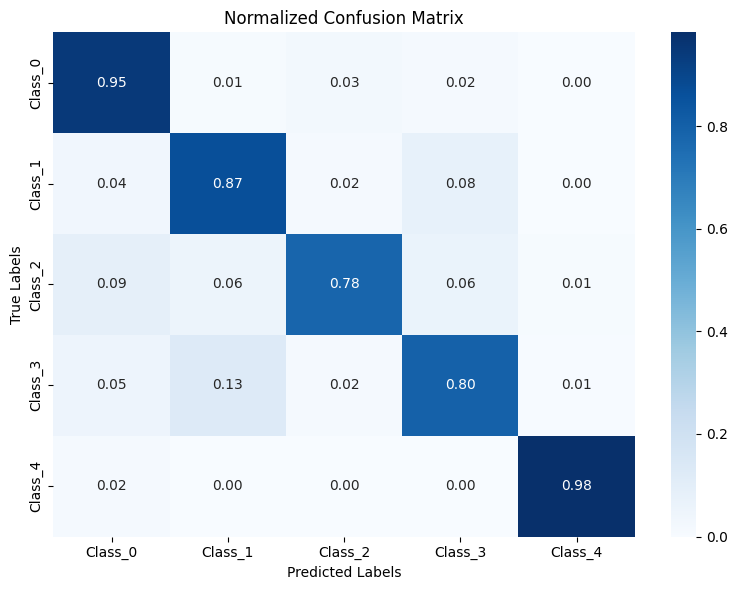


Final Results:
Accuracy: 0.8578


In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import wandb
from pathlib import Path

# Load the trained model
def load_trained_model(model_path="./wav2vec2-emotion-v2.2"):
    print(f"Loading model from {model_path}")
    
    checkpoint_path = Path(model_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Model directory {model_path} not found")
    
    checkpoint_dirs = [d for d in checkpoint_path.iterdir() if d.is_dir() and d.name.startswith('checkpoint-')]
    
    if checkpoint_dirs:
        latest_checkpoint = max(checkpoint_dirs, key=lambda x: int(x.name.split('-')[1]))
        print(f"Found checkpoint: {latest_checkpoint}")
        model = Wav2Vec2ForSequenceClassification.from_pretrained(latest_checkpoint)
    else:
        try:
            model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
        except:
            model_files = list(checkpoint_path.glob("*.bin")) + list(checkpoint_path.glob("*.safetensors"))
            if model_files:
                print(f"Found model files: {model_files}")
                model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
            else:
                raise FileNotFoundError(f"No valid model files found in {model_path}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print(f"Model loaded successfully on {device}")
    return model

# Create trainer for evaluation
def create_evaluation_trainer(model, test_dataset, collate_fn):
    training_args = TrainingArguments(
        output_dir="./temp_eval",
        per_device_eval_batch_size=4,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        report_to=[]  # disables wandb & tensorboard reporting
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=test_dataset,
        data_collator=collate_fn,
    )
    
    return trainer

# Main evaluation function
def evaluate_model(model_path="./wav2vec2-emotion-v2.2"):
    model = load_trained_model(model_path)
    trainer = create_evaluation_trainer(model, test_dataset, collate_fn)

    wandb.init(project="wav2vec2-emotion-classification", anonymous="allow", mode="disabled")  # disabled tracking

    print("Evaluating on test set...")
    predictions = trainer.predict(test_dataset)
    
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    NUM_LABELS = 5
    emotion_labels = [f"Class_{i}" for i in range(NUM_LABELS)]
    
    report = classification_report(
        y_true, y_pred, 
        target_names=emotion_labels, 
        digits=4,
        labels=list(range(NUM_LABELS))
    )
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_LABELS)))

    print("\nClassification Report:\n")
    print(report)
    print(f"Overall Accuracy: {acc:.4f}")
    
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Create table for wandb (will not actually upload since disabled)
    table_data = []
    for i, emotion in enumerate(emotion_labels):
        if emotion in report_dict:
            metrics = report_dict[emotion]
            table_data.append([
                emotion,
                metrics.get('precision', 0.0),
                metrics.get('recall', 0.0),
                metrics.get('f1-score', 0.0),
                metrics.get('support', 0)
            ])

    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true', labels=list(range(NUM_LABELS)))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred, acc, report

if __name__ == "__main__":
    # test_dataset and collate_fn must be defined before running
    model_path = "wav2vec2-emotion-v3"
    y_true, y_pred, accuracy, report = evaluate_model(model_path)

    print(f"\nFinal Results:")
    print(f"Accuracy: {accuracy:.4f}")



=== Evaluating My Model1 ===
Loading model from wav2vec2_finetuned_30epochs
Auto-detected 7 labels from model


Model loaded successfully on cpu
Using 7 labels for evaluation
Evaluating on test set...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



Results for My Model1:
Accuracy: 0.7748

Classification Report:
                precision    recall  f1-score   support
        Class_0    0.8244    0.8802    0.8514       192
        Class_1    0.7045    0.9255    0.8000       188
        Class_2    0.7514    0.7240    0.7374       192
        Class_3    0.7853    0.7202    0.7514       193
        Class_4    0.8049    0.6875    0.7416       192
        Class_5    0.7607    0.6458    0.6986       192
        Class_6    0.8806    1.0000    0.9365        59

       accuracy    0.7748                1208
      macro avg    0.7874    0.7976    0.7881      1208
   weighted avg    0.7774    0.7748    0.7717      1208


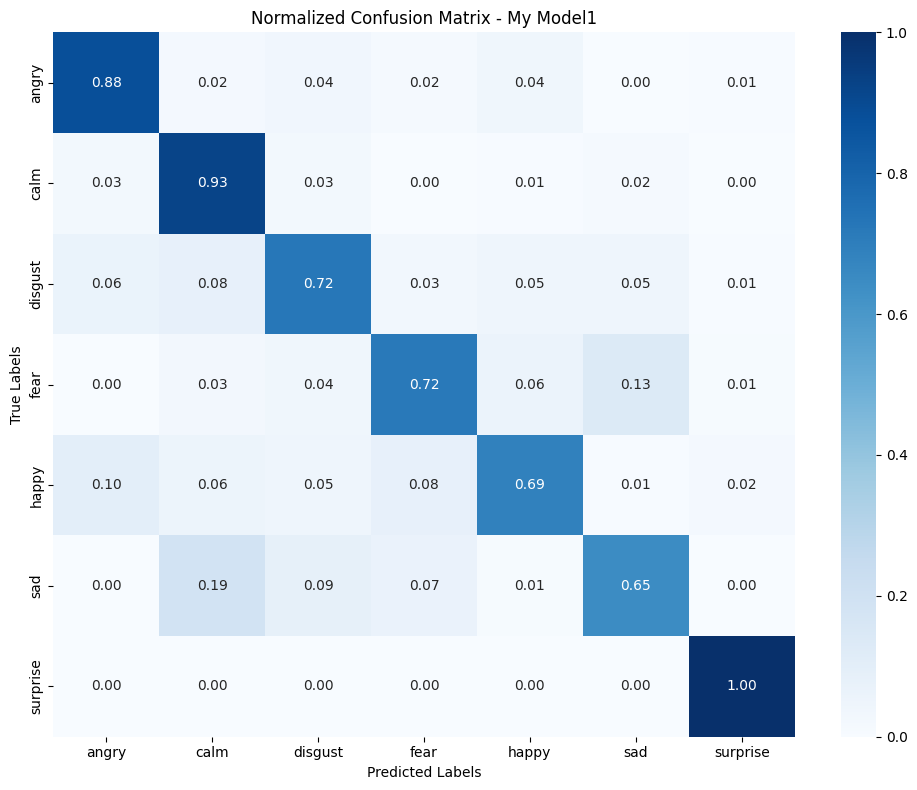

Loading model from wav2vec2_finetuned_30epochs
Auto-detected 7 labels from model
Model loaded successfully on cpu


In [21]:
single_result = evaluate_single_model(model_paths[0], test_dataset2, collate_fn, "My Model1")
trainer = create_trainer_from_path(model_paths[0], test_dataset2, collate_fn)


=== Evaluating My Model2.3 ===
Loading model from wav2vec2-emotion-v2.2/checkpoint-31447
Auto-detected 7 labels from model


Model loaded successfully on cpu
Using 7 labels for evaluation
Evaluating on test set...



Results for My Model2.3:
Accuracy: 0.6730

Classification Report:
                precision    recall  f1-score   support
        Class_0    0.7352    0.8385    0.7835       192
        Class_1    0.9009    0.5319    0.6689       188
        Class_2    0.6419    0.7188    0.6781       192
        Class_3    0.5623    0.7720    0.6507       193
        Class_4    0.6166    0.6198    0.6182       192
        Class_5    0.8286    0.4531    0.5859       192
        Class_6    0.5900    1.0000    0.7421        59

       accuracy    0.6730                1208
      macro avg    0.6965    0.7049    0.6753      1208
   weighted avg    0.7074    0.6730    0.6680      1208


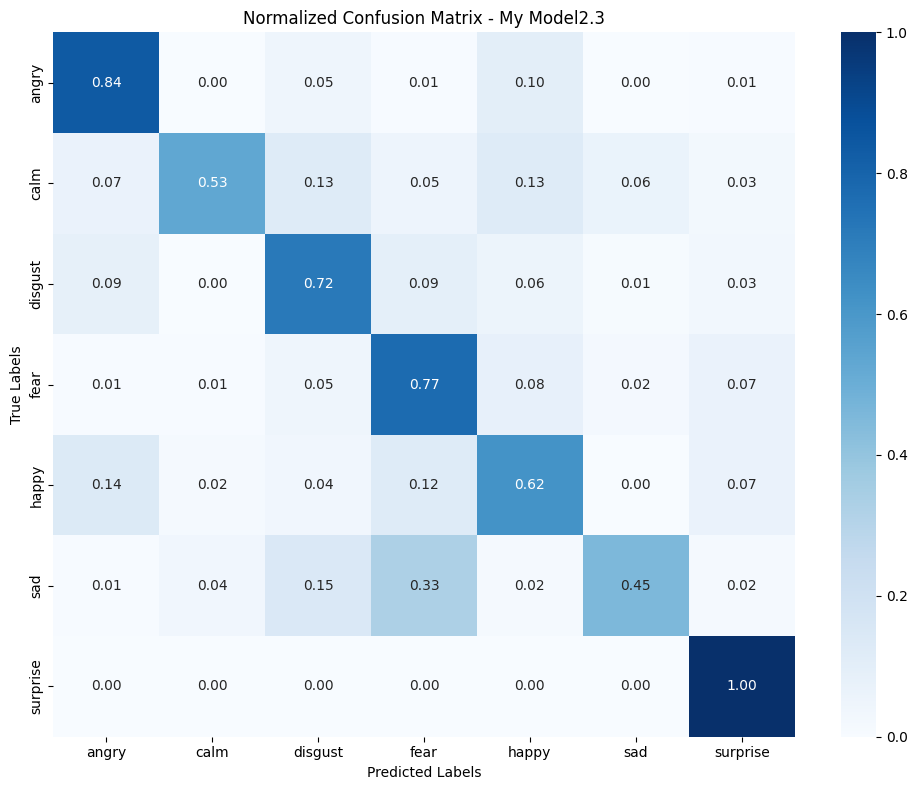

Loading model from wav2vec2-emotion-v2.2/checkpoint-31447
Auto-detected 7 labels from model
Model loaded successfully on cpu


In [22]:
single_result = evaluate_single_model(model_paths[1], test_dataset2, collate_fn, "My Model2.3")
trainer = create_trainer_from_path(model_paths[1], test_dataset2, collate_fn)

In [24]:
results = compare_models(
        model_paths=model_paths,
        test_dataset=test_dataset,
        collate_fn=collate_fn,
        model_names=model_names
    )

TypeError: compare_models() got an unexpected keyword argument 'test_dataset'

In [15]:
"""wandb.log({
    "final_test_accuracy": acc,
    "classification_report": wandb.Table(
        columns=["Class", "Precision", "Recall", "F1-Score", "Support"],
        data=[
            [label] + list(values)
            for label, values in zip(
                [f"Class_{i}" for i in range(NUM_LABELS)],
                classification_report(y_true, y_pred, output_dict=True).values()
            )
            if isinstance(values, dict)
        ]
    ),
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=y_true,
        preds=y_pred,
        class_names=[f"Class_{i}" for i in range(NUM_LABELS)]
    )
})"""